In [3]:
from processed_data import UTKFace
import matplotlib.pyplot as plt

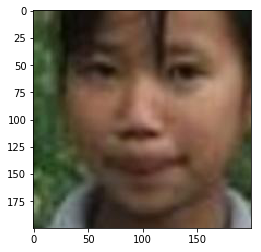

In [4]:
foo = UTKFace.Dataset(train=True)
plt.imshow(foo[0][0])

In [ ]:
train_loader = torch.utils.data.DataLoader(
    FaceDataset, shuffle=True, train=True)

In [ ]:
from __future__ import print_function
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import copy
import numpy as np


parser = argparse.ArgumentParser(description='VAE MNIST Example')
parser.add_argument('--batch-size', type=int, default=128, metavar='N',
                    help='input batch size for training (default: 128)')
parser.add_argument('--epochs', type=int, default=10, metavar='N',
                    help='number of epochs to train (default: 10)')
parser.add_argument('--no-cuda', action='store_true', default=False,
                    help='enables CUDA training')
parser.add_argument('--seed', type=int, default=1, metavar='S',
                    help='random seed (default: 1)')
parser.add_argument('--log-interval', type=int, default=10, metavar='N',
                    help='how many batches to wait before logging training status')
parser.add_argument('--load', action='store_true', default=False, help='Skip Training')
args = parser.parse_args()
args.cuda = not args.no_cuda and torch.cuda.is_available()

torch.manual_seed(args.seed)

device = torch.device("cuda" if args.cuda else "cpu")

kwargs = {'num_workers': 1, 'pin_memory': True} if args.cuda else {}
mnist_train = datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.ToTensor())
mnist_test = datasets.MNIST('../data', train=False, transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(
    mnist_train,
    batch_size=args.batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    mnist_test,
    batch_size=args.batch_size, shuffle=True, **kwargs)


class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        # 1x28x28
        self.conv1 = nn.Conv2d(1, 10, kernel_size=(2,2), stride=2)
        # 10x14x14
        self.conv2 = nn.Conv2d(10, 20, kernel_size=(2,2), stride=2)
        # 20x7x7
        self.fc21 = nn.Linear(20 * 7 * 7, 20)
        self.fc22 = nn.Linear(20 * 7 * 7, 20)
        self.fc3 = nn.Linear(20, 20 * 7 * 7)
        self.deconv1 = nn.ConvTranspose2d(20, 10, kernel_size=(2, 2), stride=2)
        self.deconv2 = nn.ConvTranspose2d(10, 1, kernel_size=(2, 2), stride=2)

    def encode(self, x):
        x = x.view(-1, 1, 28, 28)
        h1 = F.relu(self.conv1(x))
        h2 = F.relu(self.conv2(h1))
        h2 = h2.view(-1, 20*7*7)
        return self.fc21(h2), self.fc22(h2)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        h3 = h3.view(-1, 20, 7, 7)
        h4 = self.deconv1(h3)
        return torch.sigmoid(self.deconv2(h4))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)


# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD

def build_mnist_dataset_with_only_label_from_dataset(d, label, test=False):
    nd = copy.deepcopy(d)
    idxs_with_label = []

    for i in range(0, len(d)):
        if d[i][1] == label:
            idxs_with_label.append(i)

    if test:
        nd.test_data = nd.test_data[idxs_with_label]
        nd.test_labels = nd.test_labels[idxs_with_label]
    else:
        nd.data = nd.data[idxs_with_label]
        nd.targets = nd.targets[idxs_with_label]

    return nd

def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))


def test(epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            test_loss += loss_function(recon_batch, data, mu, logvar).item()
            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n],
                                      recon_batch.view(args.batch_size, 1, 28, 28)[:n]])
                save_image(comparison.cpu(),
                         'results/reconstruction_' + str(epoch) + '.png', nrow=n)

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

if __name__ == "__main__":

    if args.load:
        model.load_state_dict(torch.load('model.pt'))
        mnist_6_data = build_mnist_dataset_with_only_label_from_dataset(mnist_train, 6)
        mnist_8_data = build_mnist_dataset_with_only_label_from_dataset(mnist_train, 8)

        mu6s = []
        mu8s = []
        for x, _ in mnist_6_data:
            mu6, _ = model.encode(x.view(1, 1, 28, 28))
            mu6s.append(mu6.view(20))

        for x, _ in mnist_8_data:
            mu8, _ = model.encode(x.view(1, 1, 28, 28))
            mu8s.append(mu8.view(20))


        mu6 = torch.mean(torch.stack(mu6s), 0)
        mu8 = torch.mean(torch.stack(mu8s), 0)

        mu_diff = mu8 - mu6

        num_iter = 8

        step_vect = mu_diff / num_iter

        plt.figure(figsize=(5 * num_iter, 5))
        for i in range(num_iter):
            plt.subplot(1, num_iter, i + 1)
            curr = mu6 + i * step_vect
            img = model.decode(curr).view(28, 28).data.numpy()
            plt.imshow(img)

        plt.show()

    else:

        for epoch in range(1, args.epochs + 1):
            train(epoch)
            test(epoch)
            with torch.no_grad():
                sample = torch.randn(64, 20).to(device)
                sample = model.decode(sample).cpu()
                save_image(sample.view(64, 1, 28, 28),
                           'results/sample_' + str(epoch) + '.png')

        torch.save(model.state_dict(), 'model.pt')


In [ ]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # (W−F+2P)/S+1
        # (200, 200) -> (96, 96)
        self.conv1 = nn.Conv2d(1, 16, kernel_size=(10, 10), stride=2)
        # (96, 96) -> (45, 45)
        self.conv2 = nn.Conv2d(20, 32, kernel_size=(8, 8), stride=2)
        # (45, 45) -> (21, 21)
        self.conv3 = nn.Conv2d(20, 64, kernel_size=(5, 5), stride=2)
        # (21, 21) -> (9, 9)
        self.conv4 = nn.Conv2d(20, 128, kernel_size=(5, 5), stride=2)
        
        self.fc1 = nn.Linear(9*9*128, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv4(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 9*9*128)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
    
def train(args, model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test(args, model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

def main():
    # Training settings
    parser = argparse.ArgumentParser(description='PyTorch MNIST Example')
    parser.add_argument('--batch-size', type=int, default=64, metavar='N',
                        help='input batch size for training (default: 64)')
    parser.add_argument('--test-batch-size', type=int, default=1000, metavar='N',
                        help='input batch size for testing (default: 1000)')
    parser.add_argument('--epochs', type=int, default=10, metavar='N',
                        help='number of epochs to train (default: 10)')
    parser.add_argument('--lr', type=float, default=0.01, metavar='LR',
                        help='learning rate (default: 0.01)')
    parser.add_argument('--momentum', type=float, default=0.5, metavar='M',
                        help='SGD momentum (default: 0.5)')
    parser.add_argument('--no-cuda', action='store_true', default=False,
                        help='disables CUDA training')
    parser.add_argument('--seed', type=int, default=1, metavar='S',
                        help='random seed (default: 1)')
    parser.add_argument('--log-interval', type=int, default=10, metavar='N',
                        help='how many batches to wait before logging training status')
    
    parser.add_argument('--save-model', action='store_true', default=False,
                        help='For Saving the current Model')
    args = parser.parse_args([])
    use_cuda = not args.no_cuda and torch.cuda.is_available()

    torch.manual_seed(args.seed)

    device = torch.device("cuda" if use_cuda else "cpu")

    kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
    train_loader = torch.utils.data.DataLoader(
        FaceDataset('UTKFace', train=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                       ])),
        batch_size=args.batch_size, shuffle=True, **kwargs)
    test_loader = torch.utils.data.DataLoader(
        FaceDataset('UTKFace', train=False, transform=transforms.Compose([
                           transforms.ToTensor(),
                       ])),
        batch_size=args.test_batch_size, shuffle=True, **kwargs)


    model = Net().to(device)
    optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)

    for epoch in range(1, args.epochs + 1):
        train(args, model, device, train_loader, optimizer, epoch)
        test(args, model, device, test_loader)

    if (args.save_model):
        torch.save(model.state_dict(), "UTKFace_cnn.pt")
        

In [ ]:
%debug
main()